🔄 Đang load dữ liệu...
Phân bố lớp: [34598. 74161.  5772.  2113.   466.   845.   334.  8662.  2717.   608.
   454.]
✅ Dữ liệu đã được load. Bắt đầu xây dựng mô hình CNN...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 35, 32)            128       
                                                                 
 batch_normalization (BatchN  (None, 35, 32)           128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 18, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 18, 128)           12416     
                                                                 
 batch_normaliza

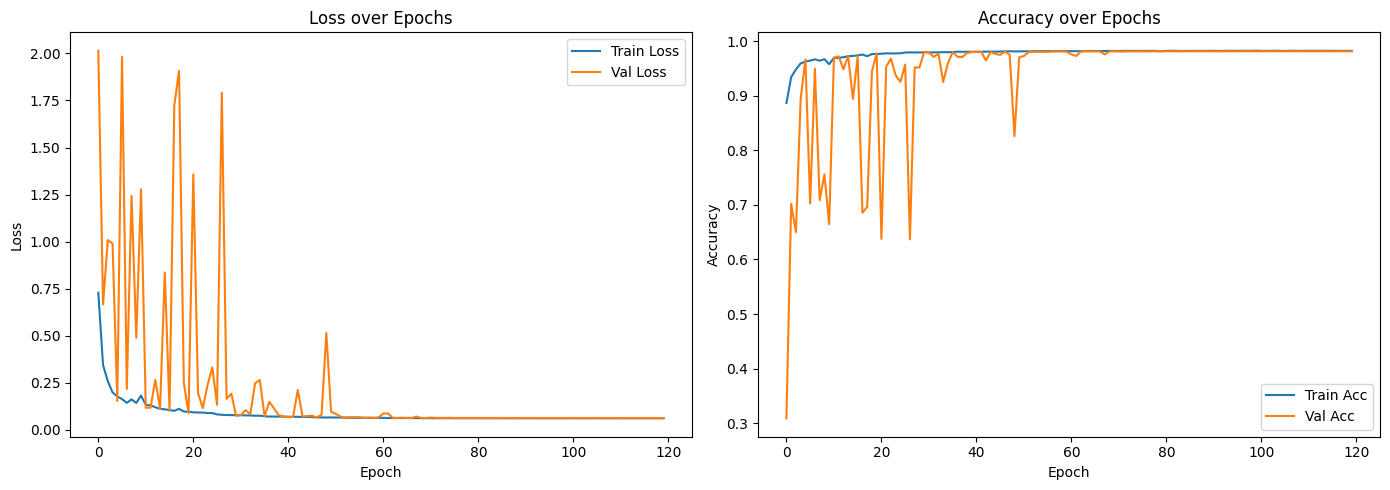

🔎 Dự đoán trên tập test...
12256/12256 [==============================] - 21s 2ms/step
📊 Ma trận nhầm lẫn:


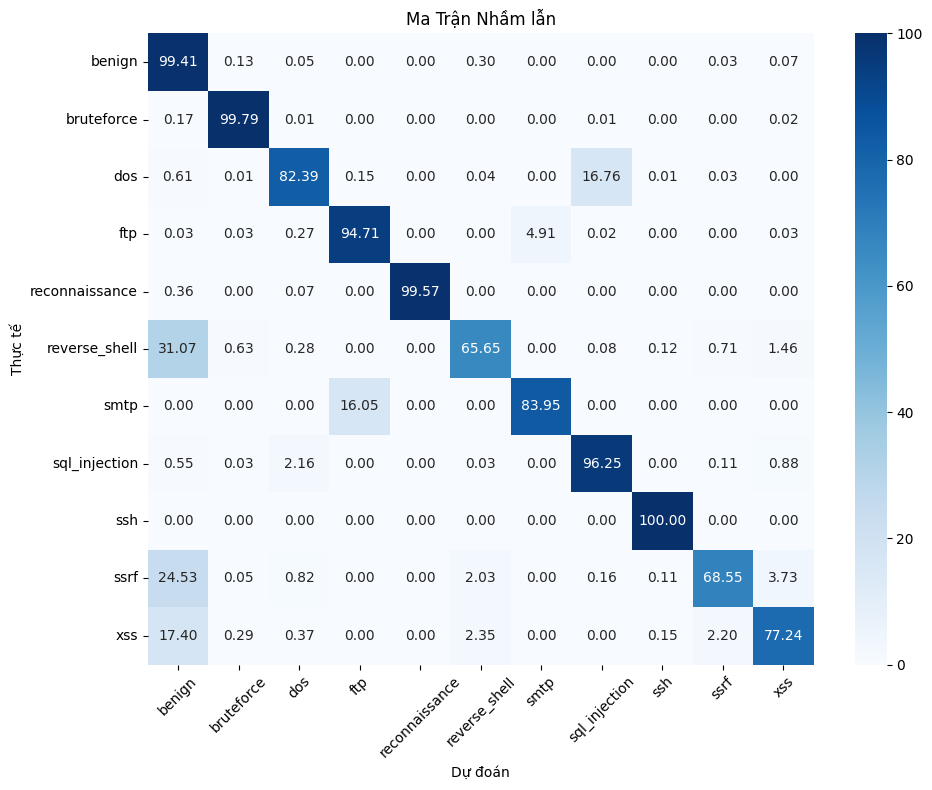


📋 Classification Report:
                precision    recall  f1-score   support

        benign     0.9800    0.9941    0.9870    103795
    bruteforce     0.9992    0.9979    0.9986    222485
           dos     0.9543    0.8239    0.8843     17317
           ftp     0.9696    0.9471    0.9583      6338
reconnaissance     1.0000    0.9957    0.9978      1397
 reverse_shell     0.8075    0.6565    0.7242      2536
          smtp     0.7296    0.8395    0.7807      1003
 sql_injection     0.8947    0.9625    0.9273     25985
           ssh     0.9988    1.0000    0.9994      8152
          ssrf     0.9191    0.6855    0.7853      1822
           xss     0.7037    0.7724    0.7364      1362

      accuracy                         0.9812    392192
     macro avg     0.9051    0.8796    0.8890    392192
  weighted avg     0.9814    0.9812    0.9809    392192


📈 Precision-Recall từng lớp:


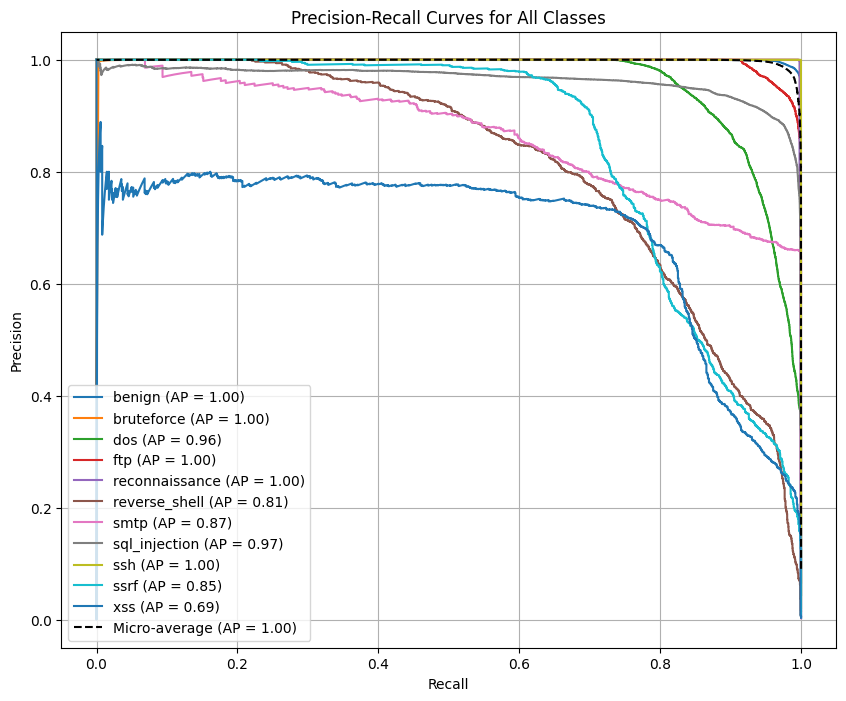


✅ Test Accuracy: 0.9812 - Test Loss: 0.0640
💾 Mô hình đã được lưu vào: cnn_webids23_model.h5


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_recall_curve, average_precision_score
from tensorflow.keras.regularizers import l2
# ==== 1. Tên lớp gộp ====
class_names = [
    'benign', 'bruteforce', 'dos', 'ftp', 'reconnaissance',
    'reverse_shell', 'smtp', 'sql_injection', 'ssh', 'ssrf', 'xss'
]

# ==== 2. Hàm reshape an toàn ====
def safe_reshape(X, n_features=63):
    if len(X.shape) == 1:
        assert X.size % n_features == 0, "Tổng phần tử không chia hết cho số đặc trưng"
        X = X.reshape(-1, n_features)
    elif X.shape[1] != n_features:
        raise ValueError(f"Số đặc trưng không đúng. Mong đợi {n_features}, nhưng nhận được {X.shape[1]}")
    return X.reshape(-1, n_features, 1)

# ==== 3. Load và xử lý dữ liệu ====
def load_data(data_path):
    X_train = np.load(os.path.join(data_path, 'X_train.npy'))
    y_train = np.load(os.path.join(data_path, 'y_train.npy'))
    X_val   = np.load(os.path.join(data_path, 'X_val.npy'))
    y_val   = np.load(os.path.join(data_path, 'y_val.npy'))
    X_test  = np.load(os.path.join(data_path, 'X_test.npy'))
    y_test  = np.load(os.path.join(data_path, 'y_test.npy'))

    X_train = safe_reshape(X_train, n_features=35)
    X_val   = safe_reshape(X_val, n_features=35)
    X_test  = safe_reshape(X_test, n_features=35)
    print("Phân bố lớp:", np.sum(y_train, axis=0))
    return X_train, y_train, X_val, y_val, X_test, y_test

# ==== Xây dựng mô hình CNN ====
def build_cnn_model(input_shape=(35, 1), num_classes=11):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same', input_shape=input_shape, 
                    kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

    model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same', 
                    kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

    model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same', 
                    kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# ==== 5. Biểu đồ training ====
def plot_history(history):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend()

    plt.tight_layout()
    plt.show()

# ==== 6. Ma trận nhầm lẫn ====
def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    
    # Chuyển thành tỷ lệ phần trăm theo hàng (theo từng lớp thực)
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_percent = np.round(cm_percent * 100, 2)  # nhân 100 và làm tròn

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Dự đoán')
    plt.ylabel('Thực tế')
    plt.title('Ma Trận Nhầm lẫn')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


# ==== 7. Precision-Recall ==== 
def plot_precision_recall(y_true_onehot, y_pred_probs, class_names):
    precision, recall, ap_score = dict(), dict(), dict()
    n_classes = y_true_onehot.shape[1]

    plt.figure(figsize=(10, 8))
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true_onehot[:, i], y_pred_probs[:, i])
        ap_score[i] = average_precision_score(y_true_onehot[:, i], y_pred_probs[:, i])
        plt.plot(recall[i], precision[i], 
                 label=f"{class_names[i]} (AP = {ap_score[i]:.2f})")

    # Micro-average (tổng hợp toàn bộ)
    precision_micro, recall_micro, _ = precision_recall_curve(y_true_onehot.ravel(), y_pred_probs.ravel())
    ap_micro = average_precision_score(y_true_onehot, y_pred_probs, average="micro")
    plt.plot(recall_micro, precision_micro,
             label=f"Micro-average (AP = {ap_micro:.2f})", color='black', linestyle='--')

    plt.title("Precision-Recall Curves for All Classes")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend(loc="lower left")
    plt.grid()
    plt.show()

# ==== 8. Main pipeline ====
def main():
    data_path = r'D:/webids23_processed_unbalanced/'
    print("🔄 Đang load dữ liệu...")
    X_train, y_train, X_val, y_val, X_test, y_test = load_data(data_path)

    print("✅ Dữ liệu đã được load. Bắt đầu xây dựng mô hình CNN...")
    model = build_cnn_model()

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    ]
    model.summary()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=150,
        batch_size=128,
        callbacks=callbacks,
        verbose=1
    )

    print("✅ Huấn luyện xong. Hiển thị biểu đồ...")
    plot_history(history)

    print("🔎 Dự đoán trên tập test...")
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    print("📊 Ma trận nhầm lẫn:")
    plot_confusion_matrix(y_true, y_pred, class_names)

    print("\n📋 Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    print("\n📈 Precision-Recall từng lớp:")
    plot_precision_recall(y_test, y_pred_probs, class_names)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\n✅ Test Accuracy: {test_acc:.4f} - Test Loss: {test_loss:.4f}")

    model.save("cnn_webids23_model.h5")
    print("💾 Mô hình đã được lưu vào: cnn_webids23_model.h5")

# ==== 9. Chạy chương trình ====
if __name__ == "__main__":
    main()
